In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np                 #not used in this nb
#from datetime import datetime      #not used in this nb

In [50]:
# function to strip the metadata:columns with only 1 unique value out of df and store in a dict with column:unique pairs
# relies on using the df.index.name as the name of key for accessing the meta_data dict from a second dictionary...
#   which stores all of the metadata dictionaries

# set df.name = '[the name of the dataframe]' before calling
# does not work with multi-index

# input:            dataframe
#                     /  \
#                    /    \
#                smaller  dict with all of the not well utilized columnar data
# output:      dataframe    


def strip_meta(df):
    meta_dict = {}
    
    # if index.name has a value, store it in the meta_dict under 'index.name'
    if df.index.name is not None:
        if df.index.name != df.name + '_meta':
            meta_dict['index.name'] = df.index.name
        else: raise UserWarning('meta_data being overwritten by strip_meta') # if the meta data has already been written
        
    df.index.name = df.name + '_meta'
    
    # DON'T NEED?? -- preserve the original columns list as meta_data
    #meta_dict['column_list'] = list(df.columns)
    # What about storing del_list in meta_data??s
    
    # go through columns, if only 1 unique value, store in meta_dict with column_name:unique pair and remove column
    del_list = []
    for col in df.columns:
        if df[col].nunique(dropna=False) == 1:
            meta_dict[col] = df.loc[df.index[0],col]
            del_list.append(col)
    if len(del_list) > 0:
        df.drop(del_list, axis = 'columns', inplace=True)
    return (df, meta_dict)

In [51]:
# read in the csv and clean down to just the 'Sample Measurement' column while saving the other columns as meta_data

meta_meta_dict = {}    #create the dictionary which will pair the meta_data key held in df.index.name to the meta_data dictionary for that df

# read in the csv
sr_25 = pd.read_csv('SantaRosaHSep-Nov17PM2.5.csv', 
                    parse_dates={'datetime_local':['Date Local','24 Hour Local'],'datetime_gmt':['Date GMT','24 Hour GMT']}) #,
#                    index_col='Date Local_24 Hour Local')

# remove END OF FILE entry if it exists from last line
if any('END OF FILE' in val for val in sr_25.iloc[-1]):
    sr_25.drop(sr_25.index.values[-1], inplace=True)

sr_25['datetime_local'] = pd.to_datetime(sr_25['datetime_local'])
sr_25.set_index('datetime_local', inplace=True)
sr_25['datetime_gmt'] = pd.to_datetime(sr_25['datetime_gmt'])
sr_25.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2167 entries, 2017-09-04 23:00:00 to 2017-11-13 01:00:00
Data columns (total 22 columns):
datetime_gmt               2167 non-null datetime64[ns]
Latitude                   2167 non-null object
Longitude                  2167 non-null float64
Datum                      2167 non-null object
Horizontal Accuracy        2167 non-null float64
State Code                 2167 non-null float64
County Code                2167 non-null float64
Site Num                   2167 non-null float64
Parameter Code             2167 non-null float64
POC                        2167 non-null float64
AQS Parameter Desc         2167 non-null object
Year GMT                   2167 non-null float64
Day In Year GMT            2167 non-null float64
Sample Measurement         2167 non-null float64
Units of Measure           2167 non-null object
Sample Duration            2167 non-null object
Sample Frequency           0 non-null float64
Detection Limit          

In [52]:
sr_25.name = 'sr_25'   # set the name attribute for use within the strip_meta function

#strip the metadata from the df
sr_25, meta_meta_dict[sr_25.index.name] = strip_meta(sr_25)

# for this particular data set, remove the GMT columns while saving their range in the meta_data
meta_meta_dict[sr_25.index.name]['datetime_gmt']=[sr_25['datetime_gmt'].min(),sr_25['datetime_gmt'].max()]
meta_meta_dict[sr_25.index.name]['Day In Year GMT']=[sr_25['Day In Year GMT'].min(),sr_25['Day In Year GMT'].max()]
sr_25.drop(['datetime_gmt', 'Day In Year GMT'], axis = 'columns', inplace=True)

sr_25.sort_index(inplace=True)

#display the results
display(sr_25.tail(12))
print(meta_meta_dict[sr_25.index.name])

,Sample Measurement,Qualifier Description
sr_25_meta,,
2017-11-30 12:00:00,5.0,NaN
2017-11-30 13:00:00,4.0,NaN
2017-11-30 14:00:00,6.0,NaN
2017-11-30 15:00:00,11.0,NaN
2017-11-30 16:00:00,8.0,NaN
2017-11-30 17:00:00,15.0,NaN
2017-11-30 18:00:00,11.0,NaN
2017-11-30 19:00:00,17.0,NaN
2017-11-30 20:00:00,13.0,NaN


{'index.name': 'datetime_local', 'Latitude': '38.403765', 'Longitude': -122.818294, 'Datum': 'WGS84', 'Horizontal Accuracy': 2.0, 'State Code': 6.0, 'County Code': 97.0, 'Site Num': 4.0, 'Parameter Code': 88101.0, 'POC': 3.0, 'AQS Parameter Desc': 'PM2.5 - Local Conditions', 'Year GMT': 2017.0, 'Units of Measure': 'Micrograms/cubic meter (LC)', 'Sample Duration': '1 HOUR', 'Sample Frequency': nan, 'Detection Limit': 5.0, 'Measurement Uncertainty': nan, 'Method Type': 'Equivalent', 'Method Description': 'Met One BAM-1020 Mass Monitor w/VSCC-Beta Attenuation', 'datetime_gmt': [Timestamp('2017-09-01 08:00:00'), Timestamp('2017-12-01 07:00:00')], 'Day In Year GMT': [244.0, 335.0]}


In [88]:
# look at sr_25 index
sr_25.info()

# find the days where readings above CUTOFF occur
CUTOFF = 50
aboveCut = sr_25.loc[sr_25['Sample Measurement'] > CUTOFF]
print(aboveCut.shape)

# create function to agg on 'Qualifier Description' column
most_common = lambda x: x.value_counts(dropna=False).index[0] if len(x.value_counts(dropna=False)) > 0 else np.NaN

# resample based on day
reCut = aboveCut.resample('D').agg({'Sample Measurement': 'max', 
                                    'Qualifier Description': most_common}) \
                                    .dropna(subset=['Sample Measurement'])
print(reCut)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2167 entries, 2017-09-01 00:00:00 to 2017-11-30 23:00:00
Data columns (total 2 columns):
Sample Measurement       2167 non-null float64
Qualifier Description    96 non-null object
dtypes: float64(1), object(1)
memory usage: 50.8+ KB
(60, 2)
            Sample Measurement Qualifier Description
sr_25_meta                                          
2017-09-03                61.0        Wildfire-U. S.
2017-09-04               104.0        Wildfire-U. S.
2017-10-09               178.0                   NaN
2017-10-10               283.0                   NaN
2017-10-11                53.0                   NaN
2017-10-13               119.0                   NaN
2017-10-14                57.0                   NaN
2017-10-15                72.0                   NaN
2017-10-16               122.0                   NaN


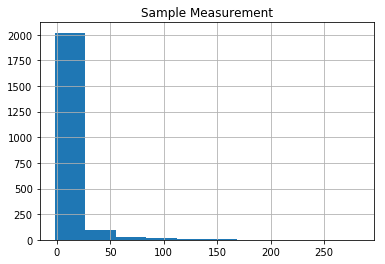

In [20]:
sr_25.shape
sr_25.hist()
plt.show()

In [21]:
wf = sr_25[sr_25['Qualifier Description']=='Wildfire-U. S.']

,Sample Measurement,Qualifier Description
sr_25_meta,,
2017-09-01 00:00:00,24.0,Wildfire-U. S.
2017-09-01 01:00:00,22.0,Wildfire-U. S.
2017-09-01 02:00:00,25.0,Wildfire-U. S.
2017-09-01 03:00:00,25.0,Wildfire-U. S.
2017-09-01 04:00:00,26.0,Wildfire-U. S.


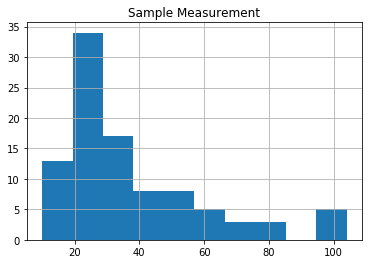

In [22]:
display(wf.head())
wf.shape
wf.hist()
plt.show()

I was surprised to find that a second column had variable data.  The 'Qualifier Description' column contains 96 values (4 days) that are categorized as being qualified with the description 'Wildfire-U. S.'  It is unclear whether this is coded as INFORM or REQEXC("required when submitting data that is affected by an Exceptional Event and for which an exclusion will be requested").

Search Wildfire on this page: https://aqs.epa.gov/aqsweb/documents/codetables/qualifiers.html
Additional information: https://www.epa.gov/aqs/aqs-code-list

Despite the following statement found here https://arb.ca.gov/aaqm/qa/drupal/ncoast_data_management.pdf:
"Most times an exceptional event such as wild fire, high winds, or fireworks occur, all of the hourly average data for the affected time periodare flagged with the appropriate “request for exclusion” flag in AQS," the qualifier code list found in the apendices only lists the INFORM version of the qualifier.

Verified that it is INFORM version of qualifier for Wildfire: IT by downloading AQSCVS version of data

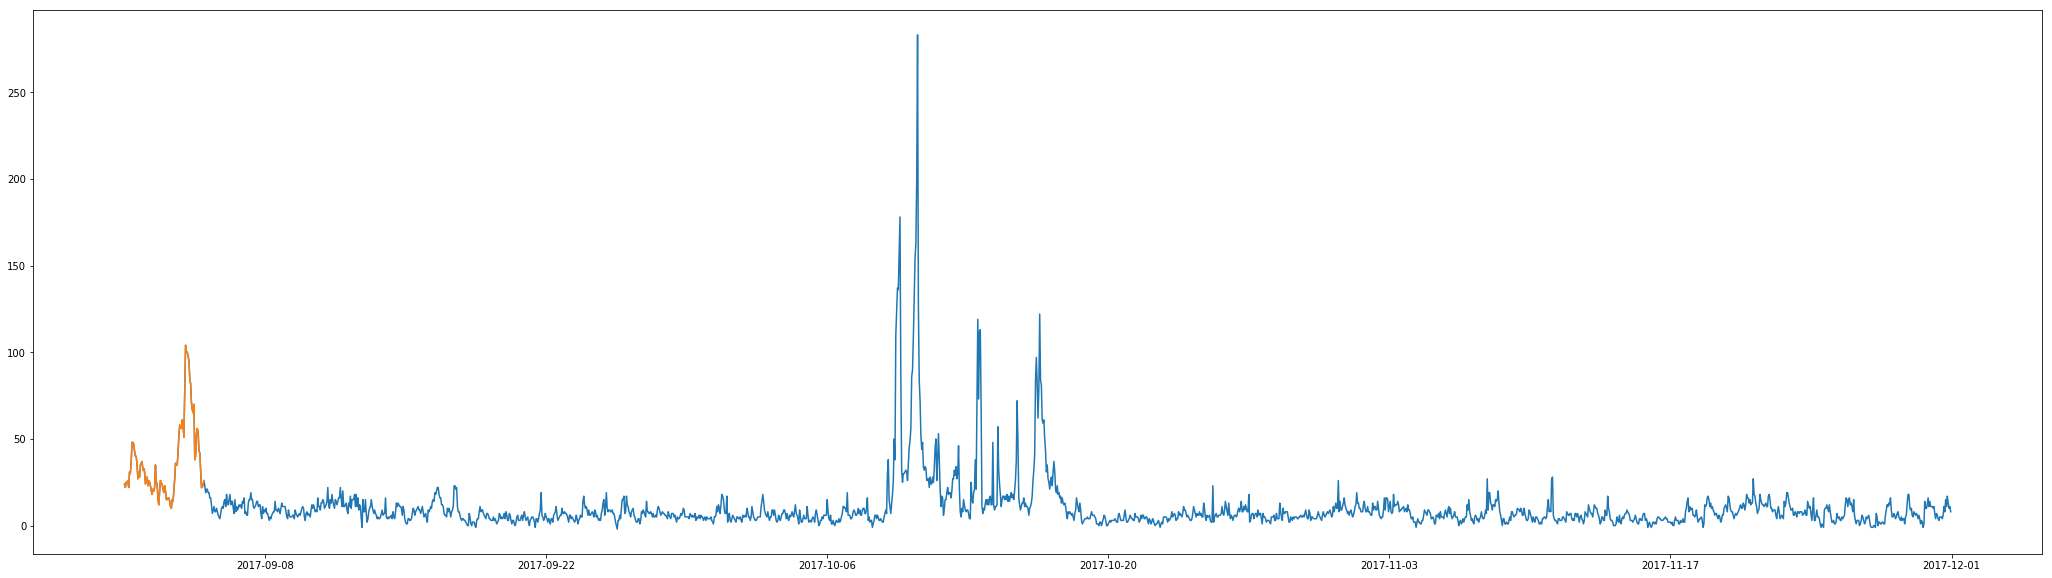

In [23]:
plt.plot(sr_25.index, sr_25['Sample Measurement'])
plt.plot(wf.index, wf['Sample Measurement'])
fig = plt.gcf()
fig.set_size_inches(36, 10)
plt.show()

In [85]:
#AQDM_1523933833.txt contains multiple readings from multiple sites for multiple parameters
# is there a way to flatten to only the parameter I'm interested in/avg of all sites?

new_data = pd.read_csv('AQDM_1523933833.txt', index_col=['datetime','site','parameter'])
#if any('END OF FILE' in val for val in new_data.iloc[-1]): #doesn't work with multi-index
    #new_data.drop(new_data.index.values[-1], inplace=True) #doesn't work when last index is NaT
new_data=new_data.iloc[:-1]   # alternate method for removing last line
new_data.name = 'new_data'   # set the name attribute for use within the strip_meta function
new_data, meta_meta_dict[new_data.index.name] = strip_meta(new_data)
new_data.sort_index(inplace=True)
display(new_data.head(12))
print(meta_meta_dict[new_data.index.name])
new_data.nunique()

data_status  duration   value  \
datetime           site         parameter                                  
20170901T0000-0800 840060970001 81102.0            1.0      60.0  49.000   
                                85101.0            0.0      60.0  50.000   
                   840060970002 81102.0            1.0      60.0  47.000   
                                85101.0            0.0      60.0  48.000   
                   840060970004 42101.0            1.0      60.0   0.400   
                                42601.0            0.0      60.0   0.200   
                                42602.0            1.0      60.0   7.200   
                                42603.0            0.0      60.0   7.400   
                                44201.0            1.0      60.0   0.010   
                                88101.0            1.0      60.0  24.000   
                   840060971003 44201.0            1.0      60.0   0.028   
                   840060973002 81102.0            1.0      60.0  26.000   

                                            unit  poc        lat         lon  \
datetime           site         parameter                                      
20170901T0000-0800 840060970001 81102.0      1.0  2.0  38.804267 -123.018142   
                                85101.0    105.0  1.0  38.804267 -123.018142   
                   840060970002 81102.0      1.0  2.0  38.610905 -122.868794   
                                85101.0    105.0  1.0  38.610905 -122.868794   
                   840060970004 42101.0      7.0  1.0  38.403765 -122.818294   
                                42601.0      8.0  1.0  38.403765 -122.818294   
                                42602.0      8.0  1.0  38.403765 -122.818294   
                                42603.0      8.0  1.0  38.403765 -122.818294   
                                44201.0      7.0  1.0  38.403765 -122.818294   
                                88101.0    105.0  3.0  38.403765 -122.818294   
                   840060971003 44201.0      7.0  1.0  38.654069 -122.901857   
                   840060973002 81102.0      1.0  1.0  38.501112 -122.998181   

                                           elev  method_code  mpc_value  \
datetime           site         parameter                                 
20170901T0000-0800 840060970001 81102.0    91.0        122.0      4.000   
                                85101.0    91.0        122.0      4.000   
                   840060970002 81102.0    30.0        122.0      4.000   
                                85101.0    30.0        122.0      4.000   
                   840060970004 42101.0    78.0         54.0      0.500   
                                42601.0    78.0         74.0     10.000   
                                42602.0    78.0         74.0      1.000   
                                42603.0    78.0         74.0     10.000   
                                44201.0    78.0         47.0      0.005   
                                88101.0    78.0        170.0      5.000   
                   840060971003 44201.0    84.0         87.0      0.005   
                   840060973002 81102.0    12.0        122.0      4.000   

                                          qualifiers  
datetime           site         parameter             
20170901T0000-0800 840060970001 81102.0          NaN  
                                85101.0          NaN  
                   840060970002 81102.0          NaN  
                                85101.0          NaN  
                   840060970004 42101.0           IT  
                                42601.0           IT  
                                42602.0           IT  
                                42603.0           IT  
                                44201.0           IT  
                                88101.0           IT  
                   840060971003 44201.0          NaN  
                   840060973002 81102.0          NaN

KeyError: None